In this notebook, we do inference on abdomen CT slices using the cascade of 2 UNETs. First to segment the liver then segment liver lesions.

Requirements:
- pip packages:
  - scipy
  - numpy
  - matplotlib
  - dicom
  - natsort
- A build of the Caffe branch at : https://github.com/mohamed-ezz/caffe/tree/jonlong
  - This branch just merges Jon Long's branch : https://github.com/longjon/caffe/ with the class weighting feature by Olaf Ronnenberg (code at http://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/).
  - Class weighting feature is not needed for inference in this notebook, but we unify the caffe dependency for training and inference tasks.

#### Download model weights and define the paths to the deploy prototxts####

In [1]:
STEP1_DEPLOY_PROTOTXT = "deploy.prototxt"
STEP1_MODEL_WEIGHTS   = "step1_weights.caffemodel"
#STEP2_DEPLOY_PROTOTXT = "../models/cascadedfcn/step2/step2_deploy.prototxt"
#STEP2_MODEL_WEIGHTS   = "../models/cascadedfcn/step2/step2_weights.caffemodel"

In [2]:
import caffe
print caffe.__file__
# Use CPU for inference
#caffe.set_mode_cpu()
# Use GPU for inference
caffe.set_mode_gpu()

import numpy as np
from matplotlib import pyplot as plt
from IPython import display
plt.set_cmap('gray')
%matplotlib inline

import scipy
import scipy.misc

/home/ee/btech/ee1130480/Caffe_Master_11012017/python/caffe/__init__.pyc


### Utility functions ###

In [3]:
IMG_DTYPE = np.float
SEG_DTYPE = np.uint8

import dicom
import natsort
import glob, os
import re
def read_dicom_series(directory, filepattern = "image_*"):
    """ Reads a DICOM Series files in the given directory. 
    Only filesnames matching filepattern will be considered"""
    
    if not os.path.exists(directory) or not os.path.isdir(directory):
        raise ValueError("Given directory does not exist or is a file : "+str(directory))
    print '\tRead Dicom',directory
    lstFilesDCM = natsort.natsorted(glob.glob(os.path.join(directory, filepattern)))
    print '\tLength dicom series',len(lstFilesDCM)
    # Get ref file
    RefDs = dicom.read_file(lstFilesDCM[0])
    # Load dimensions based on the number of rows, columns, and slices (along the Z axis)
    ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns), len(lstFilesDCM))
    # The array is sized based on 'ConstPixelDims'
    ArrayDicom = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)

    # loop through all the DICOM files
    for filenameDCM in lstFilesDCM:
        # read the file
        ds = dicom.read_file(filenameDCM)
        # store the raw image data
        ArrayDicom[:, :, lstFilesDCM.index(filenameDCM)] = ds.pixel_array

    return ArrayDicom

def read_liver_lesion_masks(masks_dirname):
    """Since 3DIRCAD provides an individual mask for each tissue type (in DICOM series format),
    we merge multiple tissue types into one Tumor mask, and merge this mask with the liver mask
    
    Args:
        masks_dirname : MASKS_DICOM directory containing multiple DICOM series directories, 
                        one for each labelled mask
    Returns:
        numpy array with 0's for background pixels, 1's for liver pixels and 2's for tumor pixels
    """
    tumor_volume = None
    liver_volume = None
    
    # For each relevant organ in the current volume
    for organ in os.listdir(masks_dirname):
        organ_path = os.path.join(masks_dirname,organ)
        if not os.path.isdir(organ_path):
            continue
        
        organ = organ.lower()
        
        if organ.startswith("livertumor") or re.match("liver.yst.*", organ) or organ.startswith("stone") or organ.startswith("metastasecto") :
            print 'Organ',masks_dirname,organ
            current_tumor = read_dicom_series(organ_path)
            current_tumor = np.clip(current_tumor,0,1)
            # Merge different tumor masks into a single mask volume
            tumor_volume = current_tumor if tumor_volume is None else np.logical_or(tumor_volume,current_tumor)
        elif organ == 'liver':
            print 'Organ',masks_dirname,organ
            liver_volume = read_dicom_series(organ_path)
            liver_volume = np.clip(liver_volume, 0, 1)
    
    # Merge liver and tumor into 1 volume with background=0, liver=1, tumor=2
    label_volume = np.zeros(liver_volume.shape)
    label_volume[liver_volume==1]=1
    label_volume[tumor_volume==1]=2
    return label_volume    
            
def stat(array):
    print 'min',np.min(array),'max',np.max(array),'median',np.median(array),'avg',np.mean(array)
def imshow(*args,**kwargs):
    """ Handy function to show multiple plots in on row, possibly with different cmaps and titles
    Usage: 
    imshow(img1, title="myPlot")
    imshow(img1,img2, title=['title1','title2'])
    imshow(img1,img2, cmap='hot')
    imshow(img1,img2,cmap=['gray','Blues']) """
    cmap = kwargs.get('cmap', 'gray')
    title= kwargs.get('title','')
    if len(args)==0:
        raise ValueError("No images given to imshow")
    elif len(args)==1:
        plt.title(title)
        plt.imshow(args[0], interpolation='none')
    else:
        n=len(args)
        if type(cmap)==str:
            cmap = [cmap]*n
        if type(title)==str:
            title= [title]*n
        plt.figure(figsize=(n*5,10))
        for i in range(n):
            plt.subplot(1,n,i+1)
            plt.title(title[i])
            plt.imshow(args[i], cmap[i])
    plt.show()
    
def to_scale(img, shape=None):

    height, width = shape
    if img.dtype == SEG_DTYPE:
        return scipy.misc.imresize(img,(height,width),interp="nearest").astype(SEG_DTYPE)
    elif img.dtype == IMG_DTYPE:
        max_ = np.max(img)
        factor = 255.0/max_ if max_ != 0 else 1
        return (scipy.misc.imresize(img,(height,width),interp="nearest")/factor).astype(IMG_DTYPE)
    else:
        raise TypeError('Error. To scale the image array, its type must be np.uint8 or np.float64. (' + str(img.dtype) + ')')


def normalize_image(img):
    """ Normalize image values to [0,1] """
    min_, max_ = float(np.min(img)), float(np.max(img))
    return (img - min_) / (max_ - min_)



### Volume Preprocessing functions ### 

In [4]:

def preprocess_lbl_slice(lbl_slc):
    """ Preprocess ground truth slice to match output prediction of the network in terms 
    of size and orientation.
    
    Args:
        lbl_slc: raw label/ground-truth slice
    Return:
        Preprocessed label slice"""
    lbl_slc = lbl_slc.astype(SEG_DTYPE)
    #downscale the label slc for comparison with the prediction
    lbl_slc = to_scale(lbl_slc , (388, 388))
    return lbl_slc

def step1_preprocess_img_slice(img_slc):
    """
    Preprocesses the image 3d volumes by performing the following :
    1- Rotate the input volume so the the liver is on the left, spine is at the bottom of the image
    2- Set pixels with hounsfield value great than 1200, to zero.
    3- Clip all hounsfield values to the range [-100, 400]
    4- Normalize values to [0, 1]
    5- Rescale img and label slices to 388x388
    6- Pad img slices with 92 pixels on all sides (so total shape is 572x572)
    
    Args:
        img_slc: raw image slice
    Return:
        Preprocessed image slice
    """      
    img_slc   = img_slc.astype(IMG_DTYPE)
    img_slc[img_slc>1200] = 0
    img_slc   = np.clip(img_slc, -100, 400)    
    img_slc   = normalize_image(img_slc)
    img_slc   = to_scale(img_slc, (388,388))
    img_slc   = np.pad(img_slc,((92,92),(92,92)),mode='reflect')
    if False:
        img_slc = histeq_processor(img_slc)

    return img_slc

def step2_preprocess_img_slice(img_p, step1_pred):
    """ Preprocess img slice using the prediction image from step1, by performing
    the following :
    1- Set non-liver pixels to 0
    2- Calculate liver bounding box
    3- Crop the liver patch in the input img
    4- Resize (usually upscale) the liver patch to the full network input size 388x388
    5- Pad image slice with 92 on all sides
    
    Args:
        img_p: Preprocessed image slice
        step1_pred: prediction image from step1
    Return: 
        The liver patch and the bounding box coordinate relative to the original img coordinates"""
    
    img = img_p[92:-92,92:-92]
    pred = step1_pred.astype(SEG_DTYPE)
    
    # Remove background !
    img = np.multiply(img,np.clip(pred,0,1))
    # get patch size
    col_maxes = np.max(pred, axis=0) # a row
    row_maxes = np.max(pred, axis=1)# a column

    nonzero_colmaxes = np.nonzero(col_maxes)[0]
    nonzero_rowmaxes = np.nonzero(row_maxes)[0]

    x1, x2 = nonzero_colmaxes[0], nonzero_colmaxes[-1]
    y1, y2 = nonzero_rowmaxes[0], nonzero_rowmaxes[-1]
    width = x2-x1
    height= y2-y1
    MIN_WIDTH = 60
    MIN_HEIGHT= 60
    x_pad = (MIN_WIDTH - width) / 2 if width < MIN_WIDTH else 0
    y_pad = (MIN_HEIGHT - height)/2 if height < MIN_HEIGHT else 0

    x1 = max(0, x1-x_pad)
    x2 = min(img.shape[1], x2+x_pad)
    y1 = max(0, y1-y_pad)
    y2 = min(img.shape[0], y2+y_pad)

    img = img[y1:y2+1, x1:x2+1]
    pred = pred[y1:y2+1, x1:x2+1]

    img = to_scale(img, (388,388))
    pred = to_scale(pred, (388,388))
    # All non-lesion is background
    pred[pred==1]=0
    #Lesion label becomes 1
    pred[pred==2]=1

    # Now do padding for UNET, which takes 572x572
    #pred=np.pad(pred,((92,92),(92,92)),mode='reflect')
    img=np.pad(img,92,mode='reflect')
    return img, (x1,x2,y1,y2)

#### Download 3DIRCAD CT volume and merge labeled masks ####

In [5]:
img=read_dicom_series("3Dircadb1.5/PATIENT_DICOM/")

	Read Dicom 3Dircadb1.5/PATIENT_DICOM/
	Length dicom series 139


In [6]:
lbl=read_liver_lesion_masks("3Dircadb1.5/MASKS_DICOM/")

Organ 3Dircadb1.5/MASKS_DICOM/ liver
	Read Dicom 3Dircadb1.5/MASKS_DICOM/liver
	Length dicom series 139


/home/ee/btech/ee1130480/python_env/venv/lib/python2.7/site-packages/ipykernel/__main__.py:68: VisibleDeprecationWarning: using a boolean instead of an integer will result in an error in the future


In [7]:
img.shape, lbl.shape

((512, 512, 139), (512, 512, 139))

#### Visualize raw input slices ####

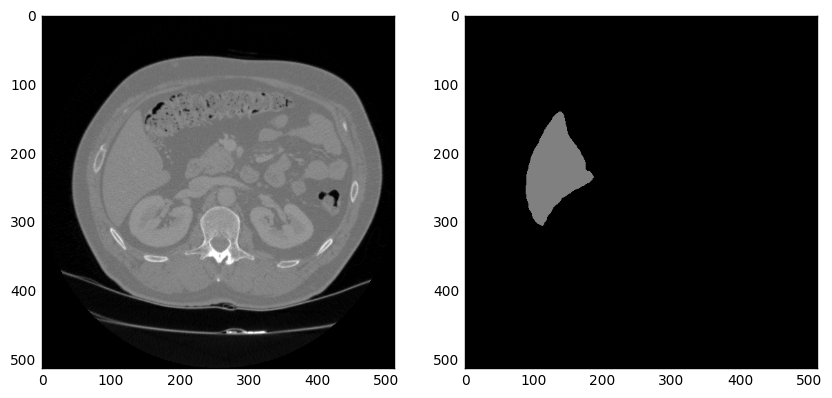

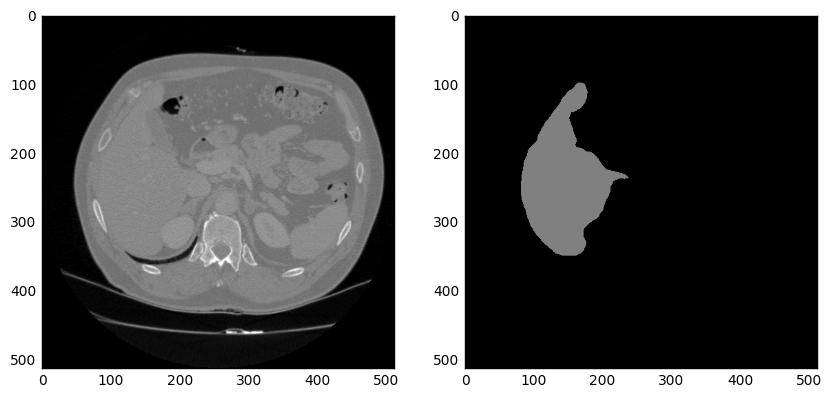

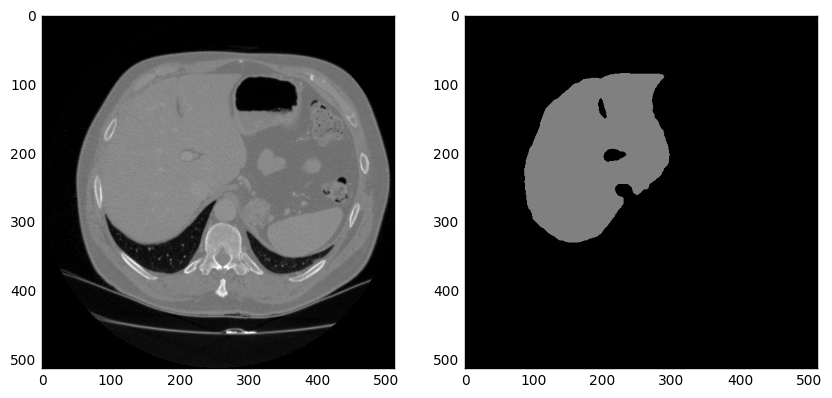

In [8]:
for s in range(50,100,20):
    imshow(img[...,s],lbl[...,s])

#### Visualize preprocessed slices ####

50


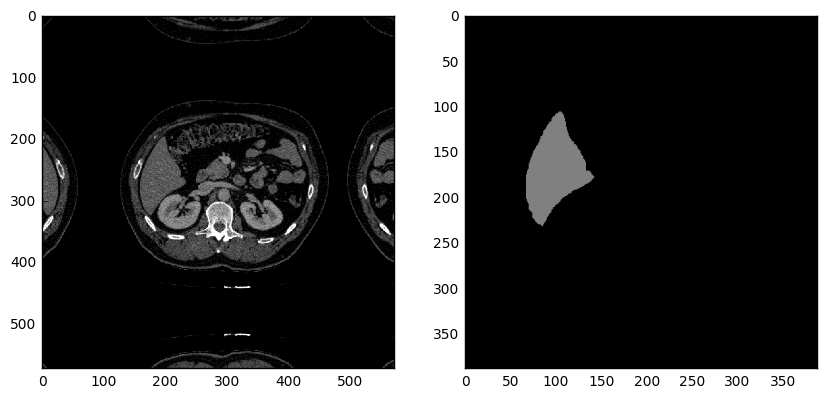

70


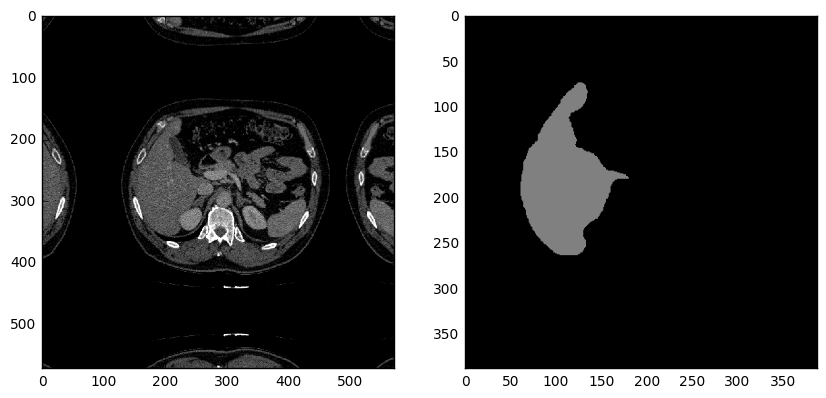

90


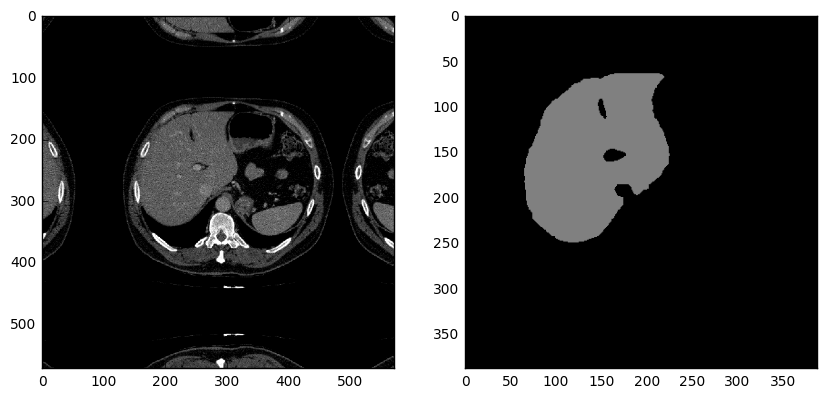

In [9]:
for s in range(50,100,20):
    print s
    img_p = step1_preprocess_img_slice(img[...,s])
    lbl_p = preprocess_lbl_slice(lbl[...,s])
    imshow(img_p,lbl_p)

### Load network prototxt and weights and perform prediction ###

#### Step 1 ####

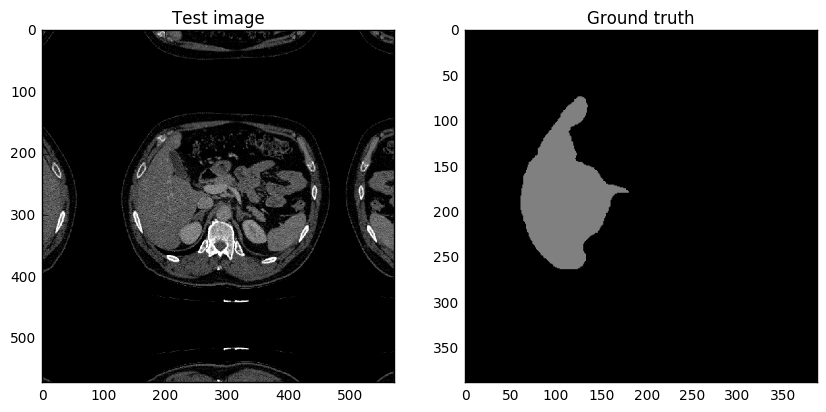

In [10]:
# Prepare a test slice
S = 70
img_p = step1_preprocess_img_slice(img[...,S])
lbl_p = preprocess_lbl_slice(lbl[...,S])
imshow(img_p,lbl_p,title=['Test image','Ground truth'])

In [11]:
# Load network
net1 = caffe.Net(STEP1_DEPLOY_PROTOTXT, STEP1_MODEL_WEIGHTS, caffe.TEST)

In [12]:
# Predict
net1.blobs['data'].data[0,0,...] = img_p
pred = net1.forward()['prob'][0,1] >0.5
print pred.shape

(388, 388)


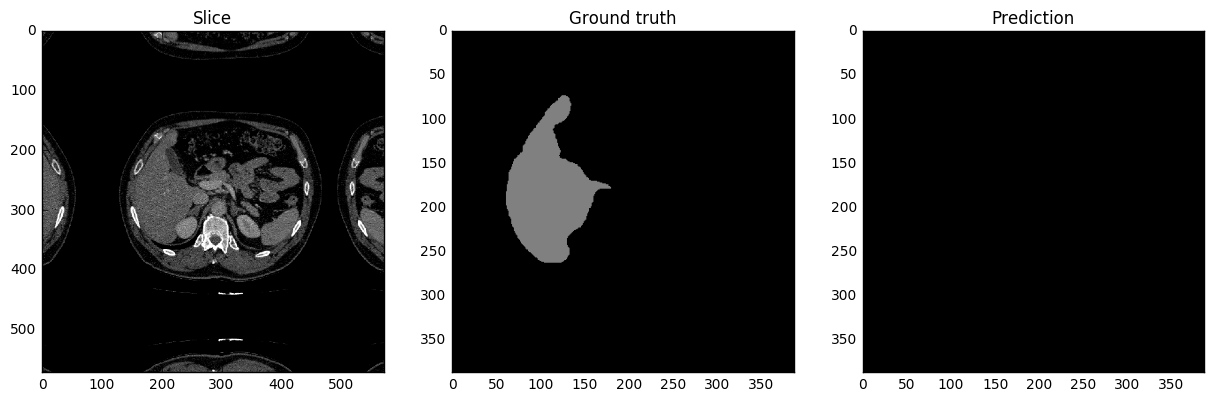

In [13]:
# Visualize results
imshow(img_p, lbl_p, pred>0.5, title=['Slice','Ground truth', 'Prediction'])